In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import random
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt
import pickle
pd.set_option('display.max_columns', 100)  # or 1000
pd.set_option('display.max_rows', 100)  # or 1000
import shap
import time
from numpy import concatenate

# Specify the path and folder

In [418]:
infile_path = 'D:\PDF_Uppsala\Training dataset\Process-based model_Jorrit'
trainning_folder = 'D:\PDF_Uppsala\Training dataset'
GBR_save_folder = 'D:\\PDF_Uppsala\\Work record\\1-Only observation scenario\\Data frequency sensitivity test\\GBR'
LSTM_save_folder = 'D:\\PDF_Uppsala\\Work record\\1-Only observation scenario\\LSTM'

In [300]:
# Load training dataset
os.chdir(trainning_folder)
all_df = pd.read_csv('Process_based_trainning_df.csv',sep = ',')
all_df['Date'] = pd.to_datetime(all_df['Date'])

In [301]:
# Specify the training year
year = [2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016] 

In [502]:
# Resample the dataset 
drop_row = []
dT = 0
i = 1
sample_df = all_df.copy()
while True:
    dT = (sample_df['Date'].iloc[i]-sample_df['Date'].iloc[i-1])/np.timedelta64(1, 'D')
    if dT<35: # set the data frequency (over 10, 14, 20 days)
        #print(sample_df['Date'].iloc[i])
        sample_df.drop(sample_df.index.values[i],axis = 0,inplace  =True)
    else:
        i+=1
    if i>=len(sample_df):break

# GBR model

In [430]:
def training_cv(df,features,nutrient,year):
    df = df[df['YY'].isin(year)]
    X_train = df[features]
    y_train = df[nutrient].values

    GBR = GradientBoostingRegressor(random_state=101)
    n_estimators = [int(x) for x in np.arange(40,140,20)]
    max_depth=[int(x) for x in np.arange(5,10,1)]
    learning_rate = [x for x in [0.01,0.1,1]]
    subsample = [x for x in [0.7,0.8,0.9,1]]
    param_grid = {'n_estimators': n_estimators,
                  'max_depth': max_depth,
                  'learning_rate':learning_rate,
                  'subsample':subsample}
    GBR_rs = RandomizedSearchCV(estimator = GBR,param_distributions = param_grid,n_iter = 30,cv = 5,verbose = 0)
    GBR_rs.fit(X_train,y_train)
    #print(GBR_rs.best_params_)
    GBR.set_params(**GBR_rs.best_params_,random_state=101).fit(X_train,y_train)
    rmse = -cross_val_score(GBR, X_train, y_train, cv=5,scoring = 'neg_root_mean_squared_error')
    r2 = cross_val_score(GBR, X_train, y_train, cv=5,scoring = 'r2')
    print('Training dataset evaluation:')
    print("RMSE %.2f (+/- %.2f)" % (rmse.mean(), rmse.std()))
    print("R2 %.2f (+/- %0.2f)" % (r2.mean(), r2.std()))
    os.chdir(GBR_save_folder)
    pickle.dump(GBR, open("GBR."+nutrient.split('(')[0]+".dat", "wb"))

In [431]:
def predict(Erken_test,df,features,nutrient,plot_from,ylim):
    #load the target GBR model
    GBR = pickle.load(open("GBR."+nutrient.split('(')[0]+".dat", "rb"))
    #predict yhat using test_X
    Erken_test[nutrient] =GBR.predict(Erken_test[features])
    nutrient_compare = Erken_test[['Date',nutrient]].merge(df[['Date',nutrient]],
                                                          how = 'inner',on = 'Date')
    nutrient_compare.columns = ['Date','Prediction','True']
    #nutrient_compare['Prediction_7d'] = Erken_Nut[nutrient]

    RMSE = mean_squared_error(nutrient_compare['True'],nutrient_compare['Prediction'],squared = False)
    #plot time-series comparison
    f2,ax2 = plt.subplots(1,2,figsize = (18,6),gridspec_kw={'width_ratios': [2, 1]})
    Erken_test.plot(x = 'Date',y =nutrient,style = 'b*',ax = ax2[0],label = 'Predicted '+nutrient)
    df[['Date',nutrient]].plot(x = 'Date',y =nutrient,style = 'ro',ms = 7,alpha = 0.7,ax = ax2[0],label = 'Observation')
    ax2[0].text(0.2, 0.8, 'RMSE:{}'.format(round(RMSE,2)), 
            horizontalalignment='center',verticalalignment='center', 
            transform=ax2[0].transAxes,fontsize='x-large')
    ax2[0].set_xlim((plot_from,pd.Timestamp(2021,2,1)))
    ax2[0].set_ylim(ylim)
    
    R2 = r2_score(nutrient_compare['True'],nutrient_compare['Prediction'])
    #plot scatter plot
    ax2[1].scatter(nutrient_compare['True'],nutrient_compare['Prediction'],s = 20,c = 'blue')
    ax2[1].plot(nutrient_compare['True'],nutrient_compare['True'],lw  =1.5,color = 'black')    
    ax2[1].set_xlabel('True value')
    ax2[1].set_ylabel('Prediction')
    ax2[1].text(0.5, 0.8, 'R2:{}'.format(round(R2,2)), 
            horizontalalignment='center',verticalalignment='center', 
            transform=ax2[1].transAxes,fontsize='x-large')
    
    return Erken_test,f2

In [504]:
# Train the model and 5-fold CV
features = ['inflow(m3/s)','AirT','Prec(mm/d)','delT','U','Humidity','CC','swr(w/m2)','Ice_d','days from iceoff',
           'NOX(mmole/m3)','NH4(mmole/m3)', 'PO4(mmole/m3)','TotP(mmole/m3)', 'Si(mmole/m3)','O2(mmole/m3)']
test_time = pd.Timestamp(2017,1,1)
training_cv(sample_df,features,'Chl(mg/m3)',year)

Training dataset evaluation:
RMSE 4.38 (+/- 1.78)
R2 0.10 (+/- 0.09)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


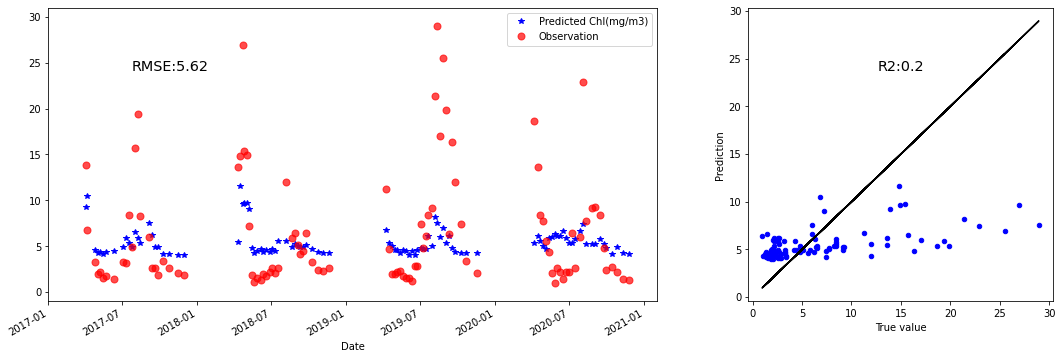

In [505]:
Erken_test = all_df[all_df['YY']>=2017]
plot_from = pd.Timestamp(2017,1,1)
ylim = (-1,31)
Erken_test, f2 = predict(Erken_test,all_df,features,'Chl(mg/m3)',plot_from,ylim)
os.chdir(GBR_save_folder)
f2.savefig('GBR_Chl.png',dpi = 500)

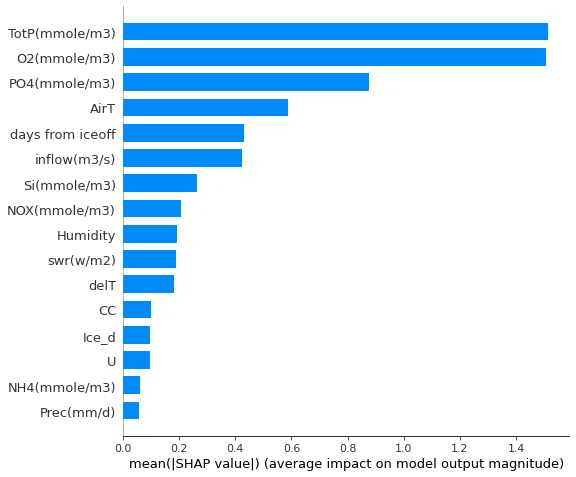

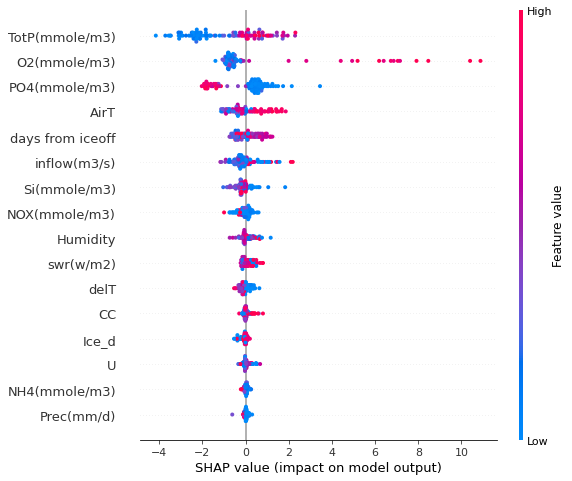

In [16]:
os.chdir(GBR_save_folder)
GBR = pickle.load(open('GBR.Chl.dat','rb'))
shap_values = shap.TreeExplainer(GBR).shap_values(Erken_test[features])
shap.summary_plot(shap_values,Erken_test[features],plot_type = 'bar')
shap.summary_plot(shap_values,Erken_test[features])

In [17]:
# Export the model results
Erken_test.to_csv('GBR predicted Chl.csv',index = False)

# LSTM model

In [303]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
Scaler = MinMaxScaler()

In [317]:
# Add the delta time feature into all_df
deltaT = []
dT = []
for i in range(1,len(all_df['Date'])):
    deltaT.append(all_df['Date'][i]-all_df['Date'][i-1])
    dT.append(deltaT[i-1]/np.timedelta64(1, 'D'))
dT.insert(0,np.nan)

all_df['Delta time'] = np.array(dT)
# delete the data points which have an over 14 days gap from previous sample point
sample_df = all_df[all_df['Delta time']<=14]

In [124]:
# convert series to supervised learning
def series_to_supervised(data, n_in, n_out, var_name,dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1] # number of variables
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [(var_name[j]+'(t-%d)' % (i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [(var_name[j]+'(t)') for j in range(n_vars)]
        else:
            names += [(var_name[j]+'(t+%d)' % (i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    agg.dropna(inplace=True)
    drop_col =[]
    for i in range(1,n_in+1):
        drop_col += [n_var*i-1]
    agg.drop(agg.iloc[:,drop_col],axis=1,inplace = True)
    return agg

In [98]:
# load dataset
def load_dataset(df,var_name):
    values = df[var_name].values
    return values

In [139]:
def sparse_dataset(data_X,data_y):
    index = []
    y = []
    for i in range(len(data_y)):
        if ~np.isnan(data_y[i]):
            index.append(i)
            y.append(data_y[i])
    X = np.stack(data_X[index,:,:])
    y = np.array(y)
    return index,X,y

In [90]:
def fit_lstm(train_X,train_y,n_batch,nb_epoch,n_neuros,dropout,verbose):
    # design network
    model = Sequential()
    model.add(LSTM(n_neuros,  return_sequences = True,
              input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(dropout))
    model.add(LSTM(n_neuros, return_sequences = True))
    model.add(Dropout(dropout))
    model.add(LSTM(n_neuros))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_X,train_y,epochs =nb_epoch,batch_size = n_batch,verbose = verbose)
    return model

In [156]:
def plot_comparison(df,y,yhat,yhat_ts,n_date,time_steps,index,rmse,r2,nutrient,date,ylim):
    # Observation time
    time = df['Date'].iloc[n_date+time_steps:].reset_index()['Date'].iloc[index] 
    # Direct comparison of observation and prediction [yhat] (data point to data point)
    pred = pd.DataFrame(concatenate((yhat.reshape(yhat.shape[0],1),y.reshape(y.shape[0],1)), axis=1),
                        index = time)
    pred.columns = ['Prediction','True value']
    # Extract the continuous timeseries from input dataset
    time_ts = df['Date'].iloc[n_date+time_steps:]
    # The continuous prediction yhat_ts 
    pred_ts = pd.DataFrame(yhat_ts,index = time_ts,columns = ['Prediction'])

    f1,ax1 = plt.subplots(1,2,figsize = (18,6),gridspec_kw={'width_ratios': [2, 1]})
    pred_ts.plot(y = 'Prediction',
                     style = 'b*',
                     ax = ax1[0])
    pred.plot(y = 'True value',style='ro',alpha = 0.7,ms = 7,ax = ax1[0])
    ax1[0].set_ylabel(nutrient)
    ax1[0].set_xlim((date,pd.Timestamp(2021,2,1)))
    ax1[0].set_ylim(ylim)
    ax1[0].text(0.7, 0.9, 'RMSE:{}'.format(round(rmse,2)), 
            horizontalalignment='center',verticalalignment='center', 
            transform=ax1[0].transAxes,fontsize='x-large')
    pred.plot(x = 'True value', y = 'Prediction',kind = 'scatter',s = 20,c = 'blue',ax = ax1[1])
    ax1[1].plot(pred['True value'],pred['True value'],lw  =1.5,color = 'black')
    ax1[1].text(0.5, 0.8, 'R2:{}'.format(round(r2,2)), 
                horizontalalignment='center',verticalalignment='center', 
                transform=ax1[1].transAxes,fontsize='x-large')
    return f1

In [163]:
def predict_ts(df,nutrient,model,n_batch,values,time_steps):
    # add the predictive values into dataset
    value_X, value_y = values[:, :-1], values[:, -1]
    value_X = value_X.reshape((value_X.shape[0], time_steps+1, int(value_X.shape[1]/(time_steps+1))))
    y_pred = Scaler.inverse_transform(model.predict(value_X,batch_size = n_batch))    
    df[nutrient].iloc[time_steps:]=y_pred[:,0]
    df[nutrient].fillna(method = 'backfill',inplace = True)
    return df

In [154]:
def split_dataset(train,test,time_steps):
    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], time_steps+1, int(train_X.shape[1]/(time_steps+1))))
    test_X = test_X.reshape((test_X.shape[0], time_steps+1, int(test_X.shape[1]/(time_steps+1))))
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    print('number of input timesteps: {}'.format(train_X.shape[1]))
    print('number of features: {}'.format(train_X.shape[2]))
    return train_X, train_y,test_X, test_y

In [146]:
# ensure all data is float
def predict_lstm(df,values,var_name,nutrient,date,n_batch,nb_epoch,n_neuros,dropout,time_steps,n_out,verbose,ylim):
    n_date = df[df['Date']<date]['Date'].count()
    train = values[:n_date, :]
    test = values[n_date:, :]
    train_X, train_y,test_X, test_y = split_dataset(train,test,time_steps)
    # fit the lstm model
    index,X,y = sparse_dataset(train_X,train_y) # stack the timeseries input together to create a 2D training input X, and a 1D lable y
    y_scaled = Scaler.fit_transform(y.reshape(-1,1))
    print('number of samples: {}'.format(len(index)))
    kf = KFold(n_splits=5, shuffle=True, random_state=101) # 5-fold cross validation
    RMSE = []
    R2 = []
    # fit the lstm model 
    for train_index, test_index in kf.split(X,y_scaled):
        #print("TRAIN:", len(train_index), "TEST:", len(test_index))
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y_scaled[train_index], y_scaled[test_index]
        model = fit_lstm(X_train,y_train,n_batch,nb_epoch,n_neuros,dropout,verbose)
        yhat = Scaler.inverse_transform(model.predict(X_test,batch_size = n_batch))
        y_test = Scaler.inverse_transform(y_test)
        rmse = sqrt(mean_squared_error(y_test, yhat))
        r2 =  r2_score(y_test, yhat)
        RMSE.append(rmse) 
        R2.append(r2)
        #print('Training RMSE: %.2f' %rmse)       
    # make a prediction
    index,X,y = sparse_dataset(test_X,test_y) # index is the time series
    yhat = Scaler.inverse_transform(model.predict(X,batch_size = n_batch))
    rmse = sqrt(mean_squared_error(y, yhat))
    r2 = r2_score(y, yhat)
    print('Test RMSE: %.2f' % rmse)
    print('Test R2: %.2f' %r2)
    # make a prediction for the whole timeseries
    yhat_ts = Scaler.inverse_transform(model.predict(test_X,batch_size = n_batch))
    figure = plot_comparison(df,y,yhat,yhat_ts,n_date,time_steps,index,rmse,r2,nutrient,date,ylim)
    return model,RMSE,R2,figure

In [308]:
# set the directory
os.chdir(LSTM_save_folder)
# date to seperate training and test sets
date = pd.Timestamp(2017,1,1)
# set the hyperparameters
n_batch = 10
nb_epoch = 200
n_neuros = 200
dropout = 0.1
time_steps = 1
n_out = 1
verbose = 0

In [309]:
# predict Chl
nutrient = 'Chl(mg/m3)'
var_name = ['delT', 'Ice_d', 'days from iceoff', 'inflow(m3/s)', 'Si(mmole/m3)', 'TotP(mmole/m3)', 
            'NH4(mmole/m3)','NOX(mmole/m3)', 'PO4(mmole/m3)', 'U', 'AirT', 'Humidity', 'CC','swr(w/m2)', 
            'Prec(mm/d)','O2(mmole/m3)', nutrient] # removed 'month' and 'SST'
values = load_dataset(sample_df,var_name) #values = values.astype('float32')
# frame as supervised learning
reframed = series_to_supervised(values,time_steps,n_out,var_name)
values = reframed.values

In [310]:
reframed.head()

,delT(t-1),Ice_d(t-1),days from iceoff(t-1),inflow(m3/s)(t-1),Si(mmole/m3)(t-1),TotP(mmole/m3)(t-1),NH4(mmole/m3)(t-1),NOX(mmole/m3)(t-1),PO4(mmole/m3)(t-1),U(t-1),AirT(t-1),Humidity(t-1),CC(t-1),swr(w/m2)(t-1),Prec(mm/d)(t-1),O2(mmole/m3)(t-1),delT(t),Ice_d(t),days from iceoff(t),inflow(m3/s)(t),Si(mmole/m3)(t),TotP(mmole/m3)(t),NH4(mmole/m3)(t),NOX(mmole/m3)(t),PO4(mmole/m3)(t),U(t),AirT(t),Humidity(t),CC(t),swr(w/m2)(t),Prec(mm/d)(t),O2(mmole/m3)(t),Chl(mg/m3)(t)
1,0.557830,106.0,13.0,0.944,0.9,0.845,0.007,0.014,0.097,3.198417,6.150833,58.041667,0.366667,751.0,0.0,471.8775,2.165685,106.0,20.0,0.929,1.5,0.594,0.214,0.507,0.194,3.702792,9.183333,90.875000,1.0000,693.1,0.2,436.7200,3.126
2,2.165685,106.0,20.0,0.929,1.5,0.594,0.214,0.507,0.194,3.702792,9.183333,90.875000,1.000000,693.1,0.2,436.7200,3.979790,106.0,28.0,0.747,2.7,0.469,0.429,0.071,0.129,4.495042,4.892917,73.625000,0.4625,618.6,0.1,380.4700,1.714
3,3.979790,106.0,28.0,0.747,2.7,0.469,0.429,0.071,0.129,4.495042,4.892917,73.625000,0.462500,618.6,0.1,380.4700,3.610600,106.0,33.0,0.607,3.6,0.657,0.071,0.143,0.097,3.901708,11.970833,60.875000,0.9000,776.0,0.0,364.0625,1.212
4,3.610600,106.0,33.0,0.607,3.6,0.657,0.071,0.143,0.097,3.901708,11.970833,60.875000,0.900000,776.0,0.0,364.0625,0.074550,106.0,41.0,0.538,6.8,0.407,0.643,0.286,0.258,2.027917,6.269167,90.958333,0.9875,252.7,2.5,358.5950,3.122
5,0.074550,106.0,41.0,0.538,6.8,0.407,0.643,0.286,0.258,2.027917,6.269167,90.958333,0.987500,252.7,2.5,358.5950,1.655167,106.0,48.0,0.515,11.4,0.500,0.857,0.143,0.161,3.642292,11.708750,61.208333,0.4000,862.0,0.1,350.7825,2.325


(315, 2, 16) (315,) (89, 2, 16) (89,)
number of input timesteps: 2
number of features: 16
number of samples: 315
Test RMSE: 5.30
Test R2: 0.32
Training dataset RMSE 5.02 (+/- 1.01)
Training dataset R2 -0.11 (+/- 0.31)
Model takes 6 min to run


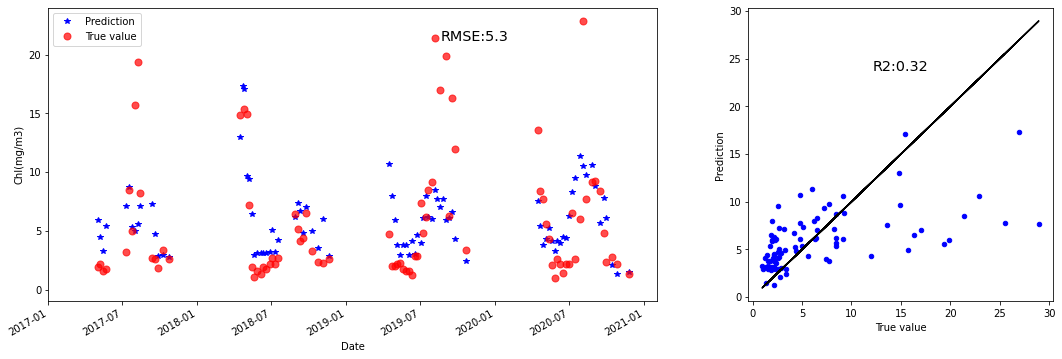

In [312]:
ylim = (-1,24)
start_time = time.time()
Chl_model,RMSE,R2,figure = predict_lstm(sample_df,values,var_name,nutrient,date,n_batch,nb_epoch,n_neuros,dropout,time_steps,n_out,verbose,ylim)
# 5-fold cross validation was used to estimate the model performance
print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
os.chdir(LSTM_save_folder)
figure.savefig('LSTM_Chl.png',dpi = 500)

In [314]:
# use the trained model to interplate the whole timeseries
Nut_memory = sample_df.copy()
Nut_memory['Chl(mg/m3)'] = np.nan
Nut_memory = predict_ts(Nut_memory,nutrient,Chl_model,n_batch,values,time_steps)
os.chdir(LSTM_save_folder)
Nut_memory.to_csv('LSTM predicted Chl.csv',index = False)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
